In [ ]:
pip install modAL

In [ ]:
import numpy as np

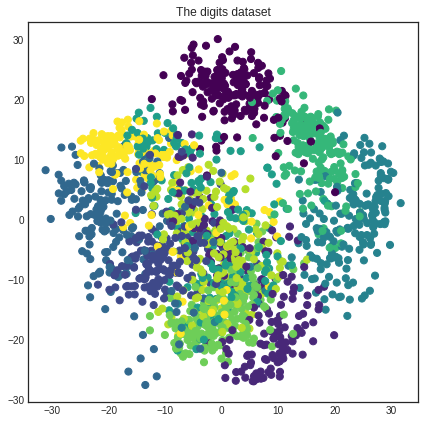

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

# loading the digits dataset
digits = load_digits()

# visualizing the classes
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(digits['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=digits['target'], cmap='viridis', s=50)
    plt.title('The digits dataset')
    plt.show()

In [ ]:
x_raw=digits["data"]
y_raw=digits["target"]

In [ ]:
n_labeled_examples = x_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=179)

In [ ]:
X_train = x_raw[training_indices]
y_train = y_raw[training_indices]

In [ ]:
X_pool = np.delete(x_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
from modAL.disagreement import max_disagreement_sampling

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

from modAL.models import ActiveLearner, Committee

# initializing Committee members
n_members = 5
learner_list = list()

learner1 = ActiveLearner(
        estimator=RandomForestClassifier(max_depth=5), X_training=X_train, y_training=y_train
    )
learner2 = ActiveLearner(estimator=AdaBoostClassifier(), X_training=X_train, y_training=y_train)
learner3 = ActiveLearner(
        estimator=DecisionTreeClassifier(max_depth=5), X_training=X_train, y_training=y_train
    )
learner4= ActiveLearner(
        estimator=KNeighborsClassifier(3), X_training=X_train, y_training=y_train
    )
learner5=ActiveLearner(
        estimator=GaussianProcessClassifier(), X_training=X_train, y_training=y_train
    )
#learner5=ActiveLearner(
#        estimator=LinearDiscriminantAnalysis(), X_training=X_train, y_training=y_train
#   )
learner_list.append(learner1)
learner_list.append(learner2)
learner_list.append(learner3)
learner_list.append(learner4)
learner_list.append(learner5)

# assembling the committee
committee = Committee(learner_list=learner_list,query_strategy=max_disagreement_sampling)

In [ ]:
#committee = Committee(learner_list=learner_list)
predictions = committee.predict(x_raw)
is_correct = (predictions == y_raw)


In [ ]:
committee.score(x_raw,y_raw)

0.9053978853644964

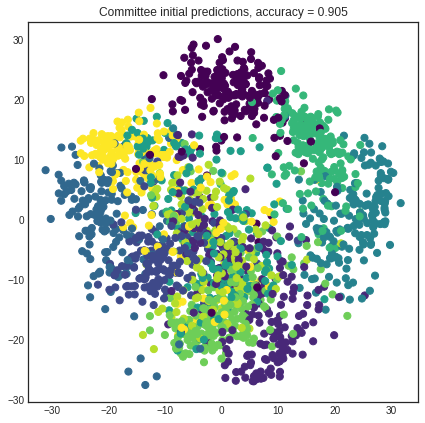

In [ ]:
unqueried_score = committee.score(digits['data'], digits['target'])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(digits['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee initial predictions, accuracy = %1.3f' % unqueried_score)
    plt.show()

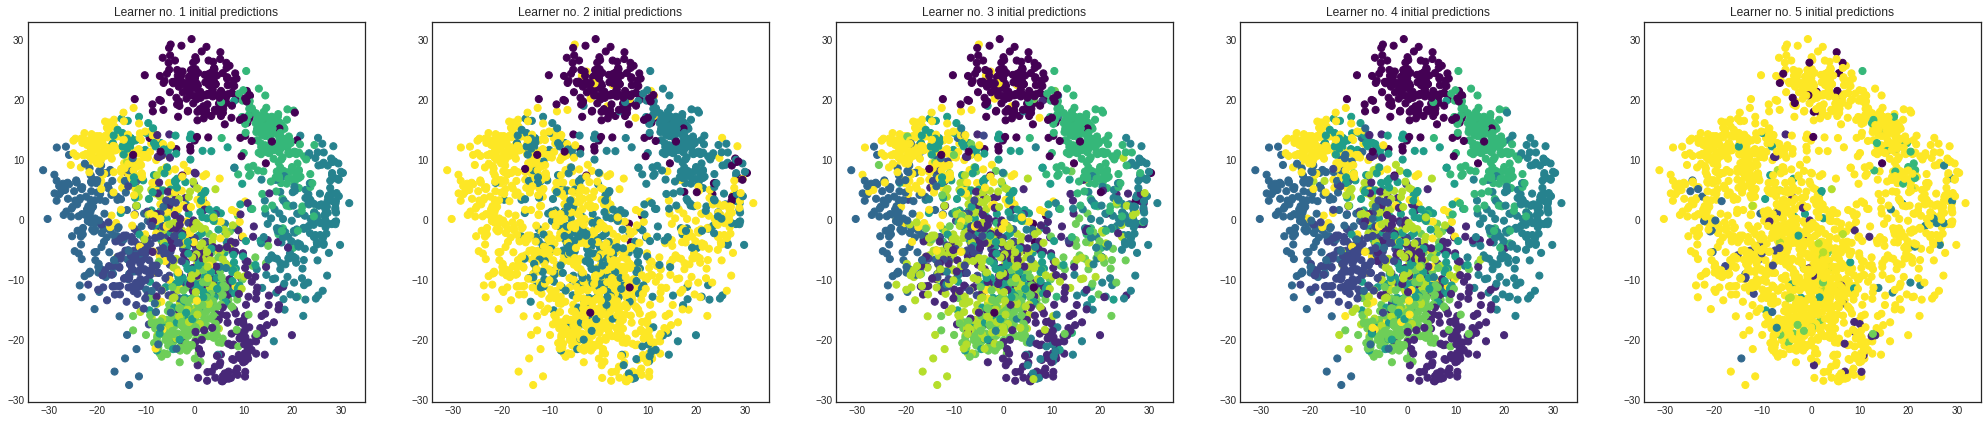

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(digits['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

In [ ]:
performance_history = [unqueried_score]

# query by committee
n_queries = 179
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(x_raw, y_raw))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

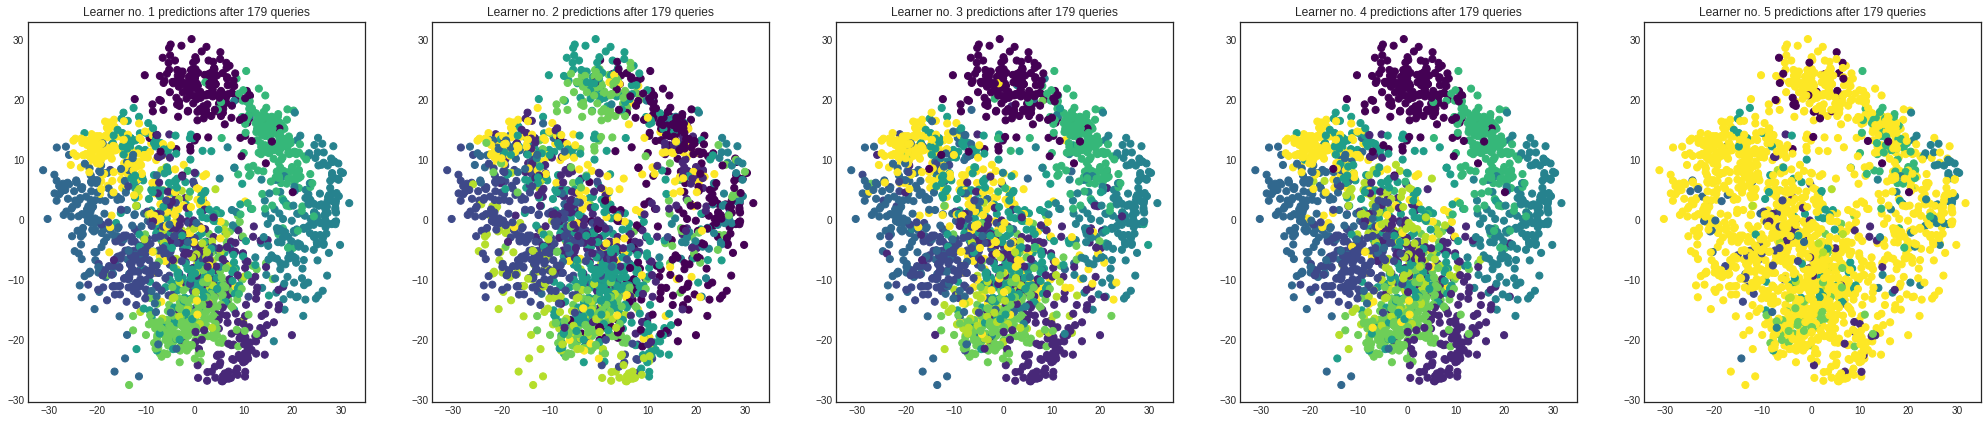

In [ ]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(digits['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries))
    plt.show()

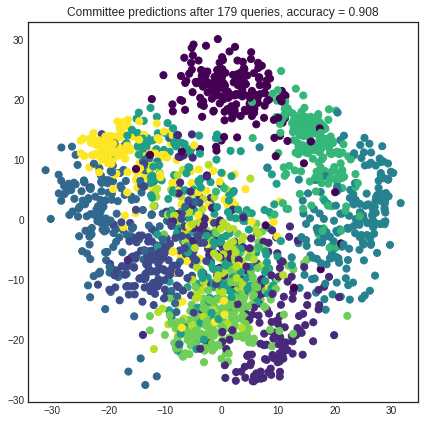

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(digits['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries, committee.score(digits['data'], digits['target'])))
    plt.show()


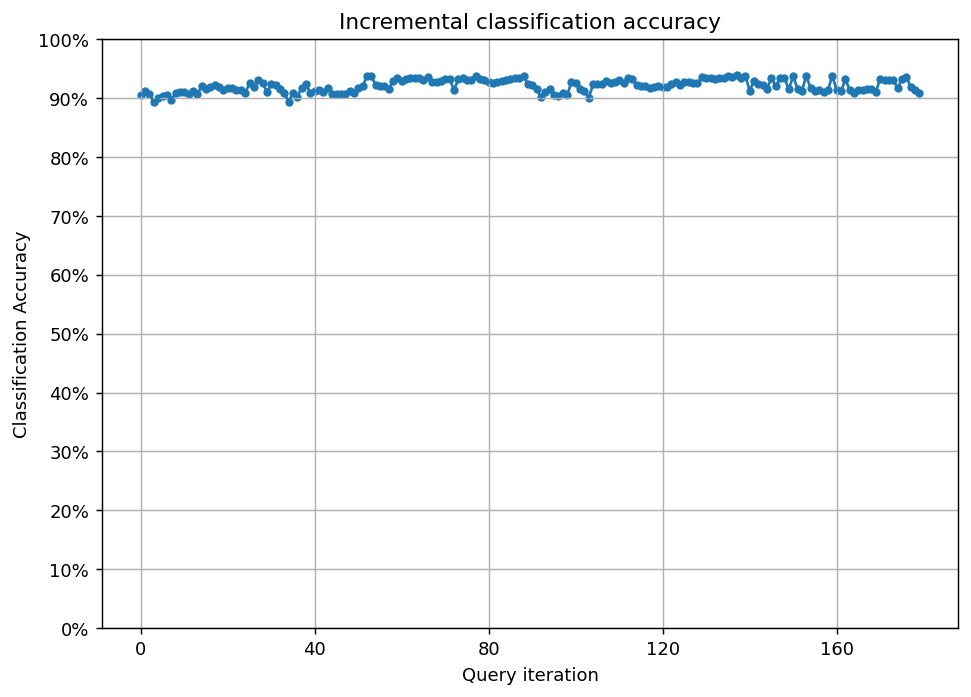

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()


The above plot shows increase in accuracy on querying each point on addition of 10% data points.

In [ ]:
performance_history = [unqueried_score]

# query by committee
n_queries = 179
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(x_raw, y_raw))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)



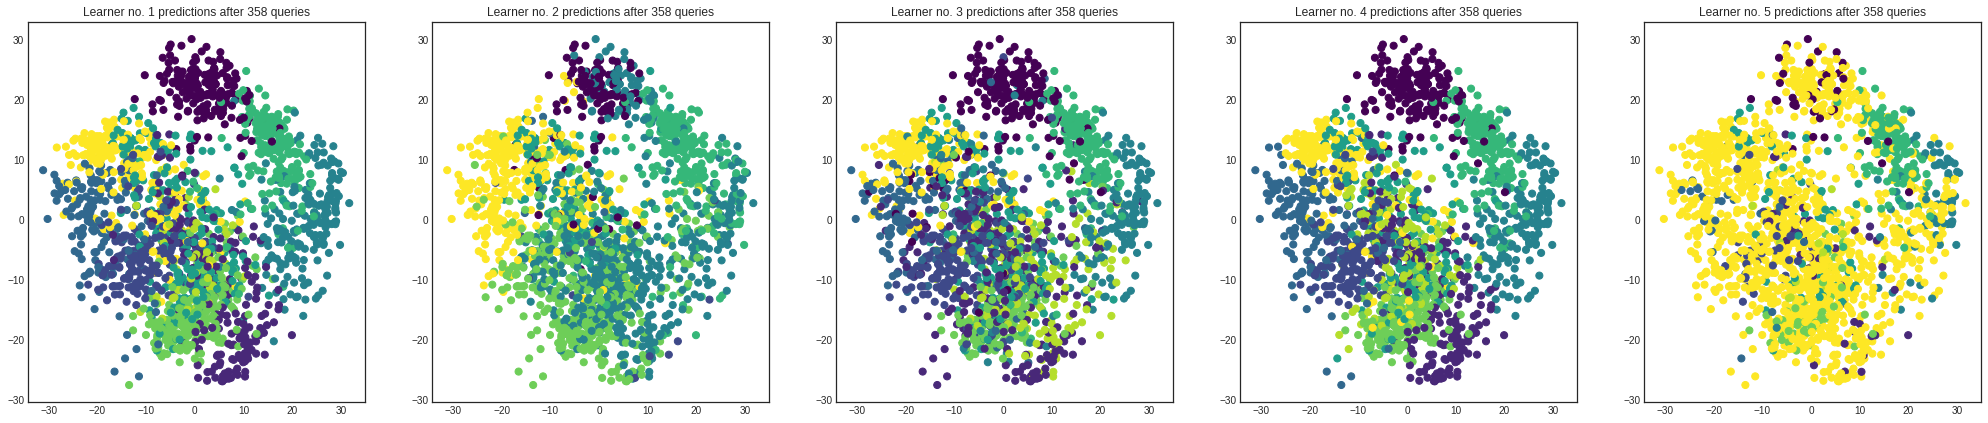

In [ ]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(digits['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries*2))
    plt.show()

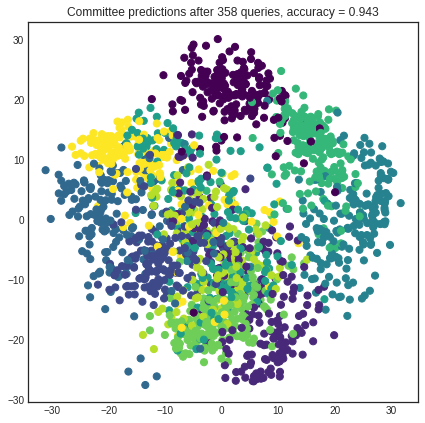

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(digits['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries*2, committee.score(digits['data'], digits['target'])))
    plt.show()


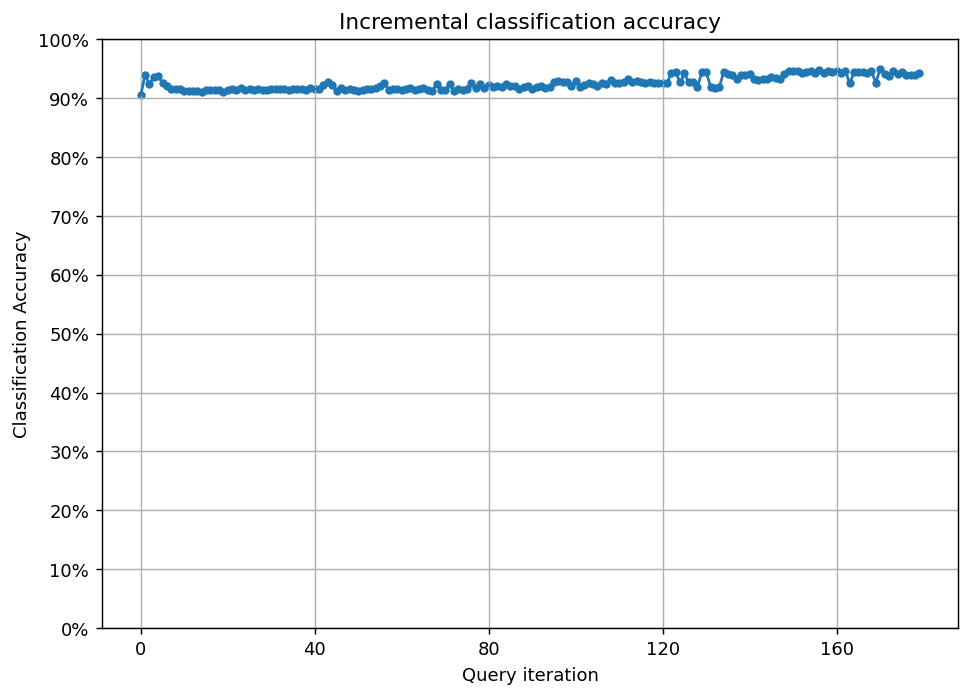

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()


In [ ]:
performance_history = [unqueried_score]

# query by committee
n_queries = 179
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(x_raw, y_raw))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)


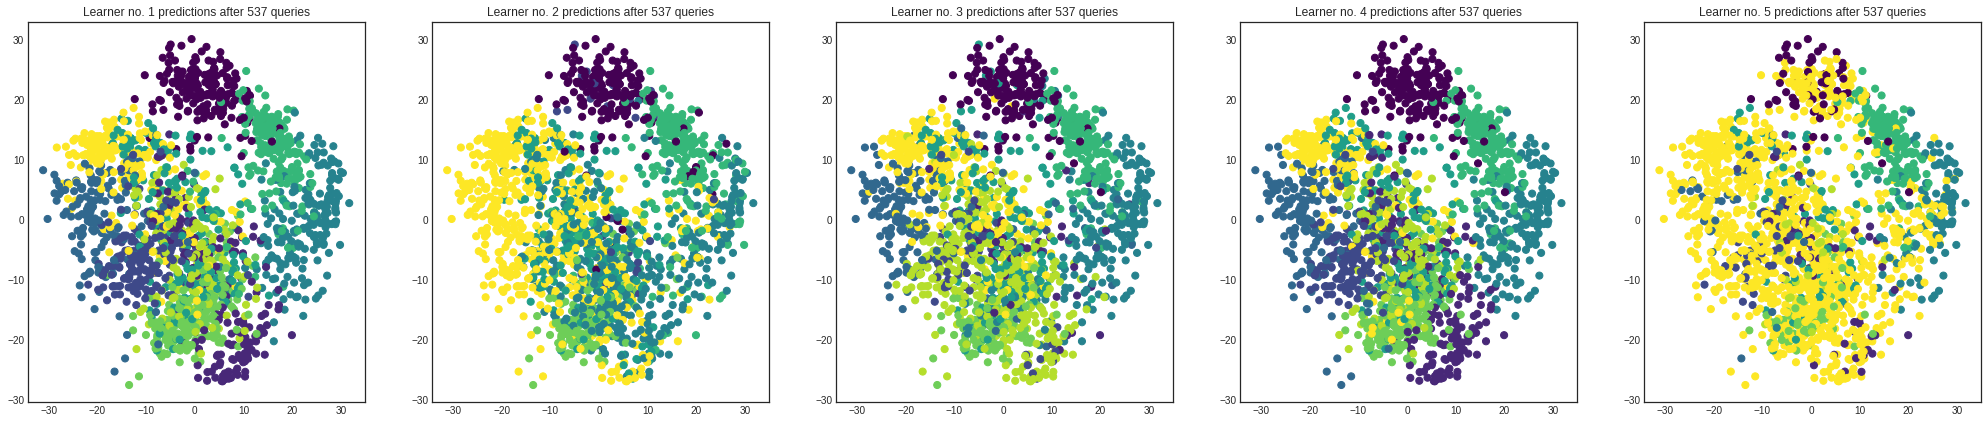

In [ ]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(digits['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries*3))
    plt.show()

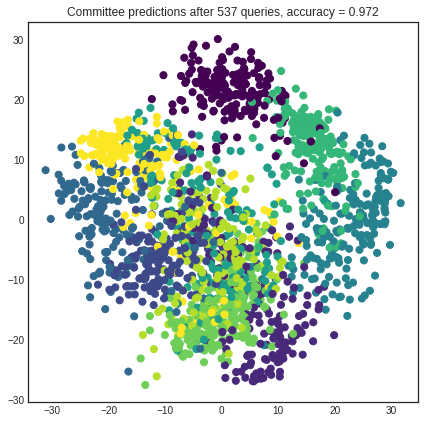

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(digits['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries*3, committee.score(digits['data'], digits['target'])))
    plt.show()


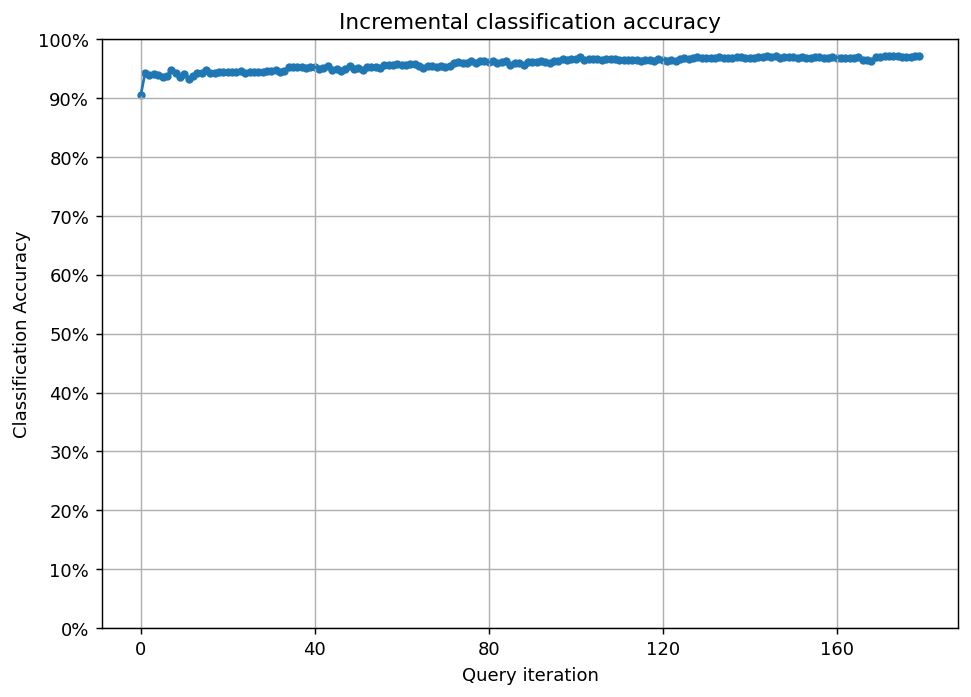

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()


In [ ]:
performance_history = [unqueried_score]

# query by committee
n_queries = 179
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(x_raw, y_raw))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)



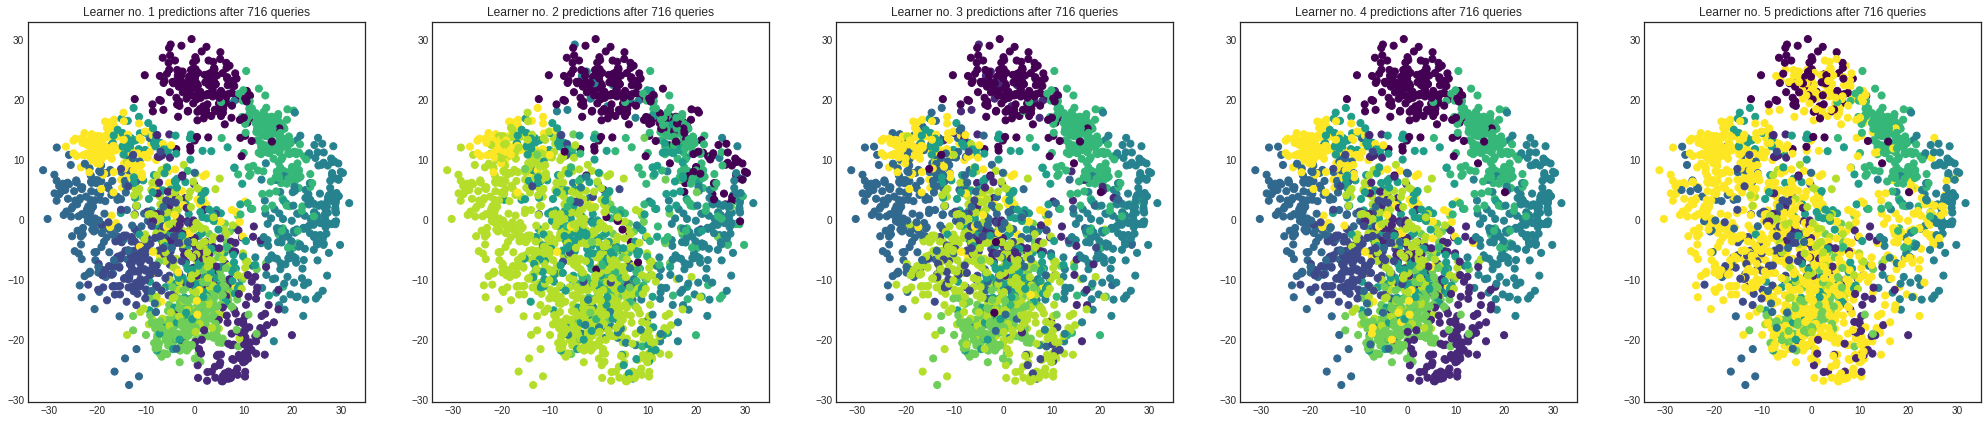

In [ ]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(digits['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries*4))
    plt.show()

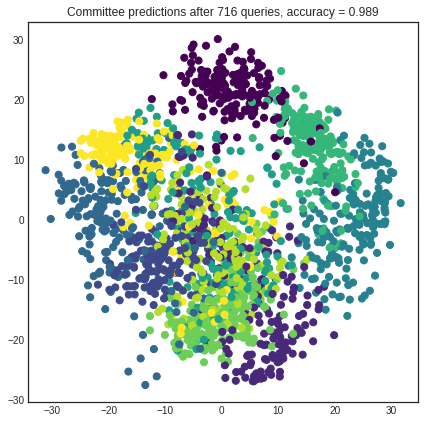

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(digits['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries*4, committee.score(digits['data'], digits['target'])))
    plt.show()


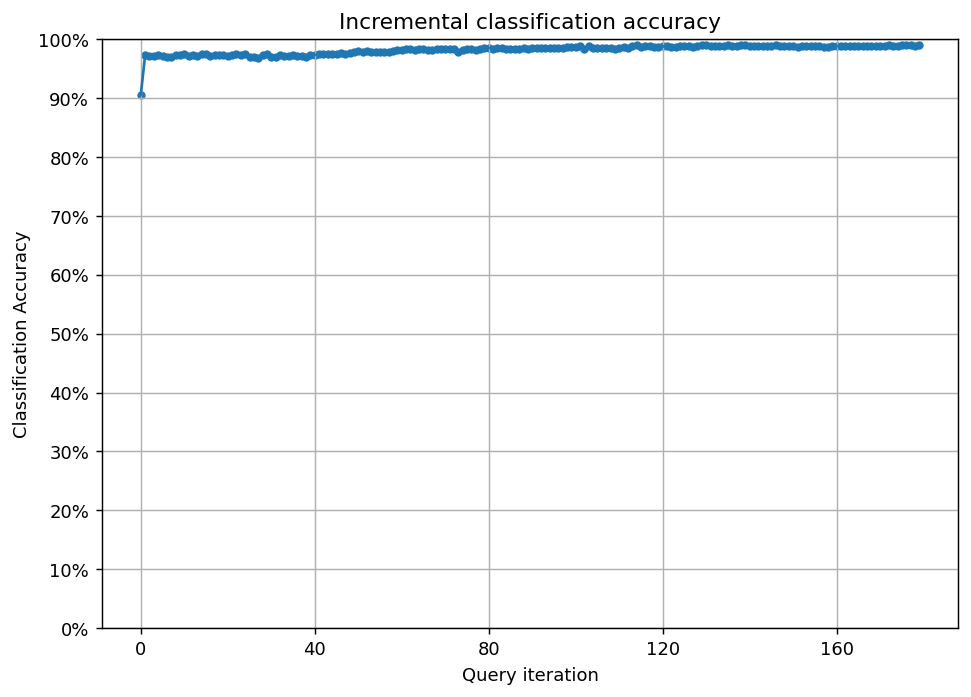

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()
